In [1]:
from pathlib import Path

import anndata as ad
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar
from scipy.stats import wilcoxon
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score

In [2]:
results_dir = Path("./results")
data_dir = Path("./data")

dlpfc_data = data_dir / "LIBD_DLPFC"
dlpfc_results = results_dir / "LIBD_DLPFC"

sdmbench_data = data_dir / "sdmbench"
sdmbench_results = results_dir / "sdmbench"

runtime_results = results_dir / "runtime_memory.tsv"

fig_dir = results_dir / "figures"

metadata_file = "downloads.tsv"

In [3]:
fig_dir.mkdir(parents=True, exist_ok=True)

In [4]:
rename_methods = {
    "leiden": "Leiden HVG PCA",
    "spatial_leiden": "SpatialLeiden HVG PCA",
    "leiden_svg": "Leiden SVG PCA",
    "spatial_leiden_svg": "SpatialLeiden SVG PCA",
    "leiden_svg_multispati": "Leiden SVG msPCA",
    "spatial_leiden_svg_multispati": "SpatialLeiden SVG msPCA",
}

# DLPFC

In [5]:
groundtruth = pd.DataFrame(
    [(f.parent.name, f) for f in dlpfc_data.glob("*/labels.tsv")],
    columns=["sample", "groundtruth"],
).set_index("sample")

results = {
    f.name: {tsv.stem: tsv for tsv in f.glob("*.tsv")}
    for f in dlpfc_results.glob("Br*")
}

label_files = (
    pd.DataFrame(results)
    .transpose()
    .merge(groundtruth, left_index=True, right_index=True)
    .rename(columns=rename_methods)
)

## Fig1a Br8100-151673

In [6]:
sample = "Br8100_151673"

px_per_um = 96.40082438014726 / 65

In [7]:
coordinate_file = dlpfc_data / sample / "coordinates.tsv"
image_file = dlpfc_data / sample / "H_E.tiff"

In [8]:
from scipy.optimize import linear_sum_assignment

data = pd.read_table(coordinate_file, index_col=0)

files = label_files.loc[sample, :].copy()
labels_df = pd.read_table(files.pop("groundtruth"), index_col=0).astype("category")
labels_df.columns = ["groundtruth"]
labels_df["groundtruth"] = labels_df["groundtruth"].cat.rename_categories(
    {n: i for i, n in enumerate(labels_df.groundtruth.cat.categories)}
)

data = data.merge(labels_df, left_index=True, right_index=True)

for name, file in files.items():
    labels_df = pd.read_table(file, index_col=0).astype("category")
    labels_df.columns = [name]

    # match clusters
    contingency_table = pd.crosstab(labels_df[name], data["groundtruth"])
    row_ind, col_ind = linear_sum_assignment(contingency_table, maximize=True)
    labels_df[name] = labels_df[name].cat.rename_categories(
        dict(zip(contingency_table.index[row_ind], contingency_table.columns[col_ind]))
    )

    data = data.merge(labels_df, left_index=True, right_index=True)

In [9]:
from PIL import Image

# disable DecompressionBombWarning
Image.MAX_IMAGE_PIXELS = None

image = np.array(Image.open(image_file))

x_crop = (data["x"].min(), data["x"].max())
y_crop = (data["y"].min(), data["y"].max())

image = image[slice(*y_crop), slice(*x_crop)]
data = data.assign(x=lambda df: df["x"] - x_crop[0], y=lambda df: df["y"] - y_crop[0])

In [10]:
scatter_kwargs = {
    "s": 6,
    "linewidth": 0,
    "hue_order": data["groundtruth"].cat.categories,
}

In [11]:
def remove_tick_and_label(ax):
    ax.set(xticklabels=[], yticklabels=[], xlabel=None, ylabel=None)
    ax.tick_params(left=False, bottom=False)


def scatter_labels(df, name, ax):
    _ = sns.scatterplot(df, x="x", y="y", hue=name, ax=ax, **scatter_kwargs)
    ax.set(title=name, aspect=1, xlim=(0, df["x"].max()), ylim=(df["y"].max(), 0))
    ax.legend([], [], frameon=False)
    remove_tick_and_label(ax)

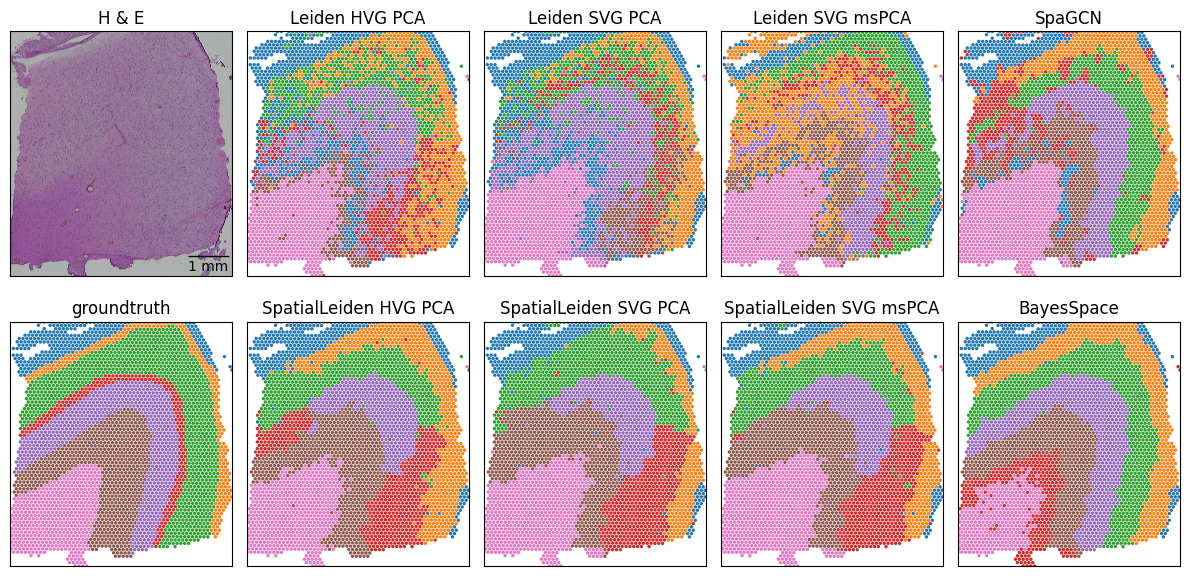

In [12]:
fig1a, axs = plt.subplots(nrows=2, ncols=5, sharex=True, sharey=True, figsize=(12, 6))
_ = axs[0, 0].imshow(image)
axs[0, 0].set(title="H & E")
remove_tick_and_label(axs[0, 0])
scale_bar = AnchoredSizeBar(
    axs[0, 0].transData, px_per_um * 1_000, r"1 mm", loc="lower right", frameon=False
)
axs[0, 0].add_artist(scale_bar)

scatter_labels(data, "groundtruth", axs[1, 0])
scatter_labels(data, "Leiden HVG PCA", axs[0, 1])
scatter_labels(data, "SpatialLeiden HVG PCA", axs[1, 1])
scatter_labels(data, "Leiden SVG PCA", axs[0, 2])
scatter_labels(data, "SpatialLeiden SVG PCA", axs[1, 2])
scatter_labels(data, "Leiden SVG msPCA", axs[0, 3])
scatter_labels(data, "SpatialLeiden SVG msPCA", axs[1, 3])
scatter_labels(data, "SpaGCN", axs[0, 4])
scatter_labels(data, "BayesSpace", axs[1, 4])

fig1a.tight_layout(h_pad=2)
fig1a.savefig(fig_dir / "Fig1a.pdf", dpi=600)

## Fig1b ARI & NMI

In [13]:
def calculate_score(fn, groundtruth, cluster, **kwargs):
    domains = pd.read_table(cluster, index_col=0)["label"].astype("category").cat.codes
    groundtruth = (
        pd.read_table(groundtruth, index_col=0)["label"].astype("category").cat.codes
    )
    common_index = domains.index.intersection(groundtruth.index)
    return fn(groundtruth.loc[common_index], domains.loc[common_index], **kwargs)


def get_ncluster(file):
    return pd.read_table(file)["label"].astype("category").cat.categories.size

In [14]:
methods = label_files.columns.to_series().loc[lambda s: s != "groundtruth"].tolist()
scores = label_files.melt(
    id_vars="groundtruth",
    value_vars=methods,
    var_name="Method",
    value_name="filepath",
    ignore_index=False,
).assign(
    ARI=lambda df: df.apply(
        lambda row: calculate_score(adjusted_rand_score, row.groundtruth, row.filepath),
        axis=1,
    ),
    NMI=lambda df: df.apply(
        lambda row: calculate_score(
            normalized_mutual_info_score, row.groundtruth, row.filepath
        ),
        axis=1,
    ),
)

In [15]:
order = [
    "Leiden HVG PCA",
    "Leiden SVG PCA",
    "Leiden SVG msPCA",
    "SpatialLeiden HVG PCA",
    "SpatialLeiden SVG PCA",
    "SpatialLeiden SVG msPCA",
    "SpaGCN",
    "BayesSpace",
]

In [16]:
# check number of clusters
label_files.map(get_ncluster).sort_index()[["groundtruth"] + order]

,groundtruth,Leiden HVG PCA,Leiden SVG PCA,Leiden SVG msPCA,SpatialLeiden HVG PCA,SpatialLeiden SVG PCA,SpatialLeiden SVG msPCA,SpaGCN,BayesSpace
Br5292_151507,7,7,7,7,7,7,7,7,7
Br5292_151508,7,7,7,7,7,7,7,7,7
Br5292_151509,7,7,7,7,7,7,7,7,7
Br5292_151510,7,7,7,7,7,7,7,7,7
Br5595_151669,5,5,5,5,5,5,5,5,5
Br5595_151670,5,5,5,5,5,5,5,4,5
Br5595_151671,5,5,5,5,5,5,5,5,5
Br5595_151672,5,5,5,5,5,5,5,5,5
Br8100_151673,7,7,7,7,7,7,7,7,7
Br8100_151674,7,7,7,7,7,7,7,6,7


In [17]:
ari_dlpfc = scores.pivot(columns="Method", values="ARI")
nmi_dlpfc = scores.pivot(columns="Method", values="NMI")

ari_dlpfc.to_csv(fig_dir / "ARI.tsv", sep="\t")
nmi_dlpfc.to_csv(fig_dir / "NMI.tsv", sep="\t")

In [18]:
ari_dlpfc.median().sort_values(ascending=False)

Method
SpatialLeiden SVG PCA      0.457925
BayesSpace                 0.452809
SpatialLeiden HVG PCA      0.444631
SpatialLeiden SVG msPCA    0.444552
SpaGCN                     0.434261
Leiden SVG msPCA           0.383711
Leiden SVG PCA             0.346216
Leiden HVG PCA             0.317458
dtype: float64

In [19]:
nmi_dlpfc.median().sort_values(ascending=False)

Method
BayesSpace                 0.600139
SpatialLeiden SVG msPCA    0.584610
SpatialLeiden SVG PCA      0.576691
SpatialLeiden HVG PCA      0.572905
SpaGCN                     0.543325
Leiden SVG msPCA           0.489733
Leiden SVG PCA             0.447682
Leiden HVG PCA             0.414988
dtype: float64

In [20]:
# best performing method per sample
ari_dlpfc.idxmax(axis=1)

Br5292_151507    SpatialLeiden SVG msPCA
Br5292_151508                 BayesSpace
Br5292_151509                 BayesSpace
Br5292_151510      SpatialLeiden SVG PCA
Br5595_151669    SpatialLeiden SVG msPCA
Br5595_151670                 BayesSpace
Br5595_151671                 BayesSpace
Br5595_151672      SpatialLeiden HVG PCA
Br8100_151673                 BayesSpace
Br8100_151674      SpatialLeiden SVG PCA
Br8100_151675                 BayesSpace
Br8100_151676                     SpaGCN
dtype: object

In [21]:
flierprops = dict(marker=".", markerfacecolor="black")

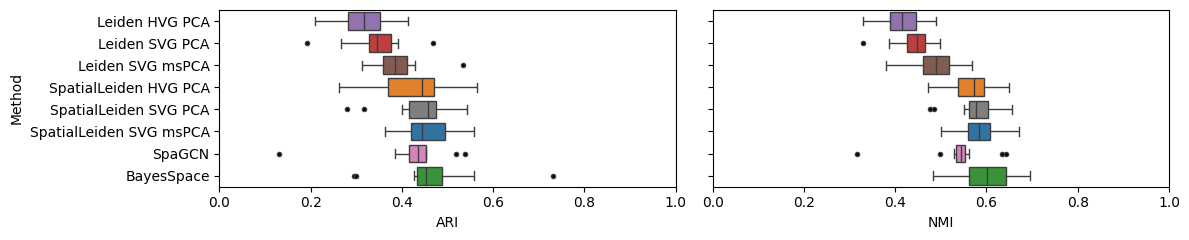

In [22]:
fig1b, axs = plt.subplots(ncols=2, figsize=(12, 2.5), sharex=True, sharey=True)
sns.boxplot(
    data=scores,
    y="Method",
    x="ARI",
    hue="Method",
    order=order,
    flierprops=flierprops,
    ax=axs[0],
)
_ = axs[0].set(xlim=(0, 1))

sns.boxplot(
    data=scores,
    y="Method",
    x="NMI",
    hue="Method",
    order=order,
    flierprops=flierprops,
    ax=axs[1],
)

fig1b.tight_layout()
fig1b.savefig(fig_dir / "Fig1b.pdf", dpi=600)

### test ARI

In [23]:
wilcoxon(
    ari_dlpfc["Leiden HVG PCA"], ari_dlpfc["SpatialLeiden HVG PCA"], alternative="less"
)

WilcoxonResult(statistic=2.0, pvalue=0.000732421875)

In [24]:
wilcoxon(
    ari_dlpfc["Leiden SVG PCA"], ari_dlpfc["SpatialLeiden SVG PCA"], alternative="less"
)

WilcoxonResult(statistic=4.0, pvalue=0.001708984375)

In [25]:
wilcoxon(
    ari_dlpfc["Leiden SVG msPCA"],
    ari_dlpfc["SpatialLeiden SVG msPCA"],
    alternative="less",
)

WilcoxonResult(statistic=2.0, pvalue=0.000732421875)

### test NMI

In [26]:
wilcoxon(
    nmi_dlpfc["Leiden HVG PCA"], nmi_dlpfc["SpatialLeiden HVG PCA"], alternative="less"
)

WilcoxonResult(statistic=0.0, pvalue=0.000244140625)

In [27]:
wilcoxon(
    nmi_dlpfc["Leiden SVG PCA"], nmi_dlpfc["SpatialLeiden SVG PCA"], alternative="less"
)

WilcoxonResult(statistic=0.0, pvalue=0.000244140625)

In [28]:
wilcoxon(
    nmi_dlpfc["Leiden SVG msPCA"],
    nmi_dlpfc["SpatialLeiden SVG msPCA"],
    alternative="less",
)

WilcoxonResult(statistic=0.0, pvalue=0.000244140625)

In [29]:
ari_dlpfc.to_csv(fig_dir / "ARI.tsv", sep="\t")
nmi_dlpfc.to_csv(fig_dir / "NMI.tsv", sep="\t")

# SDMbench comparison

In [30]:
def calculate_NMI_sdmbench(h5ad_path, label_path, **kwargs):
    domains_df = pd.read_table(label_path, index_col=0)
    # adata obs_names is always str
    domains_df.index = domains_df.index.astype(str)
    domains = domains_df["label"].astype("category").cat.codes

    groundtruth = (
        ad.read_h5ad(h5ad_path).obs["ground_truth"].astype("category").cat.codes
    )
    common_index = domains.index.intersection(groundtruth.index)

    return normalized_mutual_info_score(
        groundtruth.loc[common_index], domains.loc[common_index], **kwargs
    )

In [31]:
metadata = pd.read_table(metadata_file, index_col=0)

metadata = metadata.assign(
    path=lambda df: sdmbench_data / df["url"].str.split("/").str[-1]
)

In [32]:
sdmbench_metrics = (
    pd.read_excel(data_dir / "sdmbench_metrics.xlsx")
    .iloc[:, 3:]
    .loc[lambda df: df["DataName"].isin(metadata.index.tolist())]
    .loc[lambda df: df["Method"] != "louvain"]
)

sample2technology = (
    sdmbench_metrics.loc[:, ["DataName", "Biotech"]]
    .drop_duplicates()
    .set_index("DataName")
    .to_dict()["Biotech"]
)

In [33]:
metadata = pd.merge(
    metadata,
    pd.DataFrame(sdmbench_results.glob("*.tsv"), columns=["label_path"]).assign(
        info=lambda df: df["label_path"].map(lambda p: p.stem),
        sample=lambda df: df["info"].str.extract("(.+)_seed"),
        seed=lambda df: df["info"].str.extract("_seed(\d+)"),
        neighbors=lambda df: df["info"].str.extract("_neighbors_(.+)"),
    ),
    left_index=True,
    right_on="sample",
).set_index(["sample", "seed", "neighbors"])

In [34]:
nmi_spatialleiden = (
    metadata.apply(lambda row: calculate_NMI_sdmbench(row.path, row.label_path), axis=1)
    .to_frame("NMI")
    .reset_index()
    .assign(
        Method="SpatialLeiden",
        Biotech=lambda df: df["sample"].map(lambda x: sample2technology[x]),
    )
)

In [35]:
nmi_spatialleiden.loc[:, ["sample", "Biotech", "seed", "neighbors", "NMI"]].to_csv(
    fig_dir / "NMI_sdmbench_datasets.tsv", sep="\t", index=False
)

In [36]:
nmi_spatialleiden = (
    nmi_spatialleiden.groupby(["sample", "Biotech", "neighbors", "Method"])
    .agg({"NMI": "median"})
    .reset_index()
    .rename(columns={"sample": "DataName"})
)

In [37]:
nmi = pd.concat(
    [
        nmi_spatialleiden,
        sdmbench_metrics.loc[:, ["DataName", "Replicate", "Biotech", "Method", "NMI"]]
        .groupby(["DataName", "Method", "Biotech"])
        .agg({"NMI": "median"})
        .reset_index(),
    ]
)

## Fig2

In [38]:
def nmi_plot(nmi_df, technology, ax, cmap):
    nmi_df = nmi_df.loc[lambda df: (df["Biotech"] == technology)]

    order = nmi_df.groupby("Method").agg({"NMI": "median"}).sort_values("NMI").index

    plotting_fn = sns.barplot if nmi_df["DataName"].unique().size == 1 else sns.boxplot

    kwargs = {"palette": cmap}
    if plotting_fn == sns.boxplot:
        kwargs["flierprops"] = flierprops

    _ = plotting_fn(
        data=nmi_df, y="Method", x="NMI", hue="Method", order=order, ax=ax, **kwargs
    )
    ax.set(xlim=(0, 1), title=technology)

In [39]:
nmi = nmi.assign(
    neighbors=lambda df: df["neighbors"].replace(
        {"10": "kNN 10", "delaunay": "Delaunay", "grid4": "square"}
    )
)

nmi.loc[lambda df: df["Method"] == "SpatialLeiden", "Method"] = nmi.loc[
    lambda df: df["Method"] == "SpatialLeiden"
].assign(method=lambda df: df["Method"] + " (" + df["neighbors"] + ")")["method"]

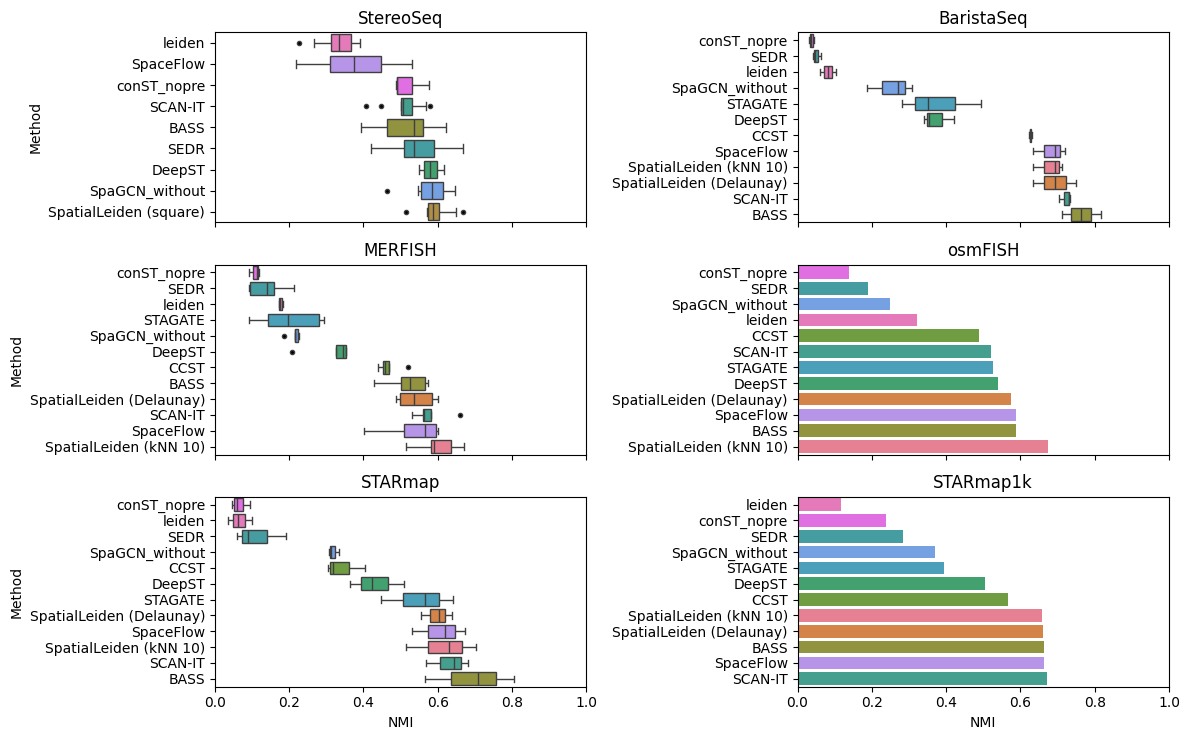

In [40]:
fig2, axs = plt.subplots(nrows=3, ncols=2, figsize=(12, 7.5), sharex=True)

methods = nmi.Method.unique()
cmap = {m: c for m, c in zip(methods, sns.color_palette("husl", len(methods)))}

nmi_plot(nmi, "StereoSeq", axs[0, 0], cmap)
nmi_plot(nmi, "BaristaSeq", axs[0, 1], cmap)
nmi_plot(nmi, "MERFISH", axs[1, 0], cmap)
nmi_plot(nmi, "osmFISH", axs[1, 1], cmap)
nmi_plot(nmi, "STARmap", axs[2, 0], cmap)
nmi_plot(nmi, "STARmap1k", axs[2, 1], cmap)

axs[0, 1].set(ylabel=None)
axs[1, 1].set(ylabel=None)
axs[2, 1].set(ylabel=None)

fig2.tight_layout()
fig2.savefig(fig_dir / "Fig2.pdf", dpi=600)

## Runtime

In [41]:
runtime_stats = (
    pd.read_table(runtime_results)
    .assign(
        sample=lambda df: df["JobName"].str.extract("(.+)_seed"),
        seed=lambda df: df["JobName"].str.extract("_seed(\d+)"),
        neighbors=lambda df: df["JobName"].str.extract("_neighbors_(.+)"),
    )
    .drop(["JobID", "JobName"], axis=1)
)

In [42]:
runtime_stats.to_csv(fig_dir / "runtime_memory.tsv", sep="\t", index=False)

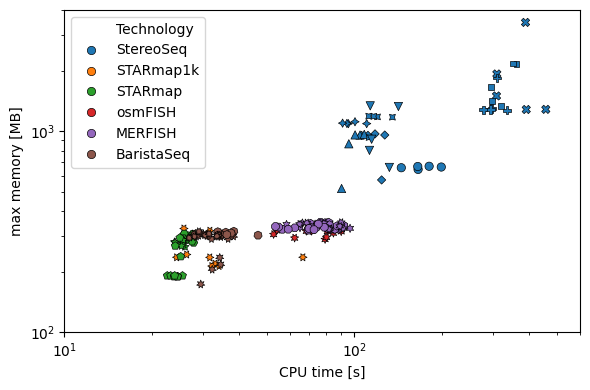

In [63]:
fig_runtime, ax = plt.subplots(figsize=(6, 4))

sns.scatterplot(
    data=runtime_stats.assign(
        Technology=lambda df: df["sample"].map(sample2technology)
    ),
    x="CPU time [s]",
    y="max memory [MB]",
    hue="Technology",
    style="sample",
    edgecolors="black",
    ax=ax,
)
_ = ax.set(xscale="log", yscale="log", xlim=(10, 600), ylim=(100, 4_000))

h, l = ax.get_legend_handles_labels()
_ = ax.legend(h[:7], l[:7], loc="upper left")

fig_runtime.tight_layout()
fig_runtime.savefig(fig_dir / "Fig_Runtime.pdf", dpi=600)